In [1]:
from src.mobile_net import MobileNetV2Encoder,mobilenet_encoders
from src.resnet_backbone import ResNetEncoder,resnet_encoders
from src.dense_net_backbone import DenseNetEncoder, densenet_encoders
from src.vgg_backbone import VGGEncoder, vgg_encoders

from src.unet_plus import UnetPlusPlus
from src.unet import Unet
import torch
import numpy as np
import pandas as pd
import json,os,sys
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
class InitialBlock(nn.Module):
    """The initial block is composed of two branches:
    1. a main branch which performs a regular convolution with stride 2;
    2. an extension branch which performs max-pooling.
    Doing both operations in parallel and concatenating their results
    allows for efficient downsampling and expansion. The main branch
    outputs 13 feature maps while the extension branch outputs 3, for a
    total of 16 feature maps after concatenation.
    Keyword arguments:
    - in_channels (int): the number of input channels.
    - out_channels (int): the number output channels.
    - kernel_size (int, optional): the kernel size of the filters used in
    the convolution layer. Default: 3.
    - padding (int, optional): zero-padding added to both sides of the
    input. Default: 0.
    - bias (bool, optional): Adds a learnable bias to the output if
    ``True``. Default: False.
    - relu (bool, optional): When ``True`` ReLU is used as the activation
    function; otherwise, PReLU is used. Default: True.
    """

    def __init__(self,
                 in_channels,
                 out_channels,
                 bias=False,
                 relu=True):
        super().__init__()

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - As stated above the number of output channels for this
        # branch is the total minus 3, since the remaining channels come from
        # the extension branch
        self.main_branch = nn.Conv2d(
            in_channels,
            out_channels - 3,
            kernel_size=3,
            stride=2,
            padding=1,
            bias=bias)

        # Extension branch
        self.ext_branch = nn.MaxPool2d(3, stride=2, padding=1)

        # Initialize batch normalization to be used after concatenation
        self.batch_norm = nn.BatchNorm2d(out_channels)

        # PReLU layer to apply after concatenating the branches
        self.out_activation = activation()

    def forward(self, x):
        main = self.main_branch(x)
        ext = self.ext_branch(x)

        # Concatenate branches
        out = torch.cat((main, ext), 1)

        # Apply batch normalization
        out = self.batch_norm(out)

        return self.out_activation(out)


class RegularBottleneck(nn.Module):
    """Regular bottlenecks are the main building block of ENet.
    Main branch:
    1. Shortcut connection.
    Extension branch:
    1. 1x1 convolution which decreases the number of channels by
    ``internal_ratio``, also called a projection;
    2. regular, dilated or asymmetric convolution;
    3. 1x1 convolution which increases the number of channels back to
    ``channels``, also called an expansion;
    4. dropout as a regularizer.
    Keyword arguments:
    - channels (int): the number of input and output channels.
    - internal_ratio (int, optional): a scale factor applied to
    ``channels`` used to compute the number of
    channels after the projection. eg. given ``channels`` equal to 128 and
    internal_ratio equal to 2 the number of channels after the projection
    is 64. Default: 4.
    - kernel_size (int, optional): the kernel size of the filters used in
    the convolution layer described above in item 2 of the extension
    branch. Default: 3.
    - padding (int, optional): zero-padding added to both sides of the
    input. Default: 0.
    - dilation (int, optional): spacing between kernel elements for the
    convolution described in item 2 of the extension branch. Default: 1.
    asymmetric (bool, optional): flags if the convolution described in
    item 2 of the extension branch is asymmetric or not. Default: False.
    - dropout_prob (float, optional): probability of an element to be
    zeroed. Default: 0 (no dropout).
    - bias (bool, optional): Adds a learnable bias to the output if
    ``True``. Default: False.
    - relu (bool, optional): When ``True`` ReLU is used as the activation
    function; otherwise, PReLU is used. Default: True.
    """

    def __init__(self,
                 channels,
                 internal_ratio=4,
                 kernel_size=3,
                 padding=0,
                 dilation=1,
                 asymmetric=False,
                 dropout_prob=0,
                 bias=False,
                 relu=True):
        super().__init__()

        # Check in the internal_scale parameter is within the expected range
        # [1, channels]
        if internal_ratio <= 1 or internal_ratio > channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_scale={1}."
                               .format(channels, internal_ratio))

        internal_channels = channels // internal_ratio

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - shortcut connection

        # Extension branch - 1x1 convolution, followed by a regular, dilated or
        # asymmetric convolution, followed by another 1x1 convolution, and,
        # finally, a regularizer (spatial dropout). Number of channels is constant.

        # 1x1 projection convolution
        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(
                channels,
                internal_channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # If the convolution is asymmetric we split the main convolution in
        # two. Eg. for a 5x5 asymmetric convolution we have two convolution:
        # the first is 5x1 and the second is 1x5.
        if asymmetric:
            self.ext_conv2 = nn.Sequential(
                nn.Conv2d(
                    internal_channels,
                    internal_channels,
                    kernel_size=(kernel_size, 1),
                    stride=1,
                    padding=(padding, 0),
                    dilation=dilation,
                    bias=bias), nn.BatchNorm2d(internal_channels), activation(),
                nn.Conv2d(
                    internal_channels,
                    internal_channels,
                    kernel_size=(1, kernel_size),
                    stride=1,
                    padding=(0, padding),
                    dilation=dilation,
                    bias=bias), nn.BatchNorm2d(internal_channels), activation())
        else:
            self.ext_conv2 = nn.Sequential(
                nn.Conv2d(
                    internal_channels,
                    internal_channels,
                    kernel_size=kernel_size,
                    stride=1,
                    padding=padding,
                    dilation=dilation,
                    bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # 1x1 expansion convolution
        self.ext_conv3 = nn.Sequential(
            nn.Conv2d(
                internal_channels,
                channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(channels), activation())

        self.ext_regul = nn.Dropout2d(p=dropout_prob)

        # PReLU layer to apply after adding the branches
        self.out_activation = activation()

    def forward(self, x):
        # Main branch shortcut
        main = x

        # Extension branch
        ext = self.ext_conv1(x)
        ext = self.ext_conv2(ext)
        ext = self.ext_conv3(ext)
        ext = self.ext_regul(ext)

        # Add main and extension branches
        out = main + ext

        return self.out_activation(out)


class DownsamplingBottleneck(nn.Module):
    """Downsampling bottlenecks further downsample the feature map size.
    Main branch:
    1. max pooling with stride 2; indices are saved to be used for
    unpooling later.
    Extension branch:
    1. 2x2 convolution with stride 2 that decreases the number of channels
    by ``internal_ratio``, also called a projection;
    2. regular convolution (by default, 3x3);
    3. 1x1 convolution which increases the number of channels to
    ``out_channels``, also called an expansion;
    4. dropout as a regularizer.
    Keyword arguments:
    - in_channels (int): the number of input channels.
    - out_channels (int): the number of output channels.
    - internal_ratio (int, optional): a scale factor applied to ``channels``
    used to compute the number of channels after the projection. eg. given
    ``channels`` equal to 128 and internal_ratio equal to 2 the number of
    channels after the projection is 64. Default: 4.
    - return_indices (bool, optional):  if ``True``, will return the max
    indices along with the outputs. Useful when unpooling later.
    - dropout_prob (float, optional): probability of an element to be
    zeroed. Default: 0 (no dropout).
    - bias (bool, optional): Adds a learnable bias to the output if
    ``True``. Default: False.
    - relu (bool, optional): When ``True`` ReLU is used as the activation
    function; otherwise, PReLU is used. Default: True.
    """

    def __init__(self,
                 in_channels,
                 out_channels,
                 internal_ratio=4,
                 return_indices=False,
                 dropout_prob=0,
                 bias=False,
                 relu=True):
        super().__init__()

        # Store parameters that are needed later
        self.return_indices = return_indices

        # Check in the internal_scale parameter is within the expected range
        # [1, channels]
        if internal_ratio <= 1 or internal_ratio > in_channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_scale={1}. "
                               .format(in_channels, internal_ratio))

        internal_channels = in_channels // internal_ratio

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - max pooling followed by feature map (channels) padding
        self.main_max1 = nn.MaxPool2d(
            2,
            stride=2,
            return_indices=return_indices)

        # Extension branch - 2x2 convolution, followed by a regular, dilated or
        # asymmetric convolution, followed by another 1x1 convolution. Number
        # of channels is doubled.

        # 2x2 projection convolution with stride 2
        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels,
                internal_channels,
                kernel_size=2,
                stride=2,
                bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # Convolution
        self.ext_conv2 = nn.Sequential(
            nn.Conv2d(
                internal_channels,
                internal_channels,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # 1x1 expansion convolution
        self.ext_conv3 = nn.Sequential(
            nn.Conv2d(
                internal_channels,
                out_channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(out_channels), activation())

        self.ext_regul = nn.Dropout2d(p=dropout_prob)

        # PReLU layer to apply after concatenating the branches
        self.out_activation = activation()

    def forward(self, x):
        # Main branch shortcut
        if self.return_indices:
            main, max_indices = self.main_max1(x)
        else:
            main = self.main_max1(x)

        # Extension branch
        ext = self.ext_conv1(x)
        ext = self.ext_conv2(ext)
        ext = self.ext_conv3(ext)
        ext = self.ext_regul(ext)

        # Main branch channel padding
        n, ch_ext, h, w = ext.size()
        ch_main = main.size()[1]
        padding = torch.zeros(n, ch_ext - ch_main, h, w)

        # Before concatenating, check if main is on the CPU or GPU and
        # convert padding accordingly
        if main.is_cuda:
            padding = padding.cuda()

        # Concatenate
        main = torch.cat((main, padding), 1)

        # Add main and extension branches
        out = main + ext

        return self.out_activation(out), max_indices


class UpsamplingBottleneck(nn.Module):
    """The upsampling bottlenecks upsample the feature map resolution using max
    pooling indices stored from the corresponding downsampling bottleneck.
    Main branch:
    1. 1x1 convolution with stride 1 that decreases the number of channels by
    ``internal_ratio``, also called a projection;
    2. max unpool layer using the max pool indices from the corresponding
    downsampling max pool layer.
    Extension branch:
    1. 1x1 convolution with stride 1 that decreases the number of channels by
    ``internal_ratio``, also called a projection;
    2. transposed convolution (by default, 3x3);
    3. 1x1 convolution which increases the number of channels to
    ``out_channels``, also called an expansion;
    4. dropout as a regularizer.
    Keyword arguments:
    - in_channels (int): the number of input channels.
    - out_channels (int): the number of output channels.
    - internal_ratio (int, optional): a scale factor applied to ``in_channels``
     used to compute the number of channels after the projection. eg. given
     ``in_channels`` equal to 128 and ``internal_ratio`` equal to 2 the number
     of channels after the projection is 64. Default: 4.
    - dropout_prob (float, optional): probability of an element to be zeroed.
    Default: 0 (no dropout).
    - bias (bool, optional): Adds a learnable bias to the output if ``True``.
    Default: False.
    - relu (bool, optional): When ``True`` ReLU is used as the activation
    function; otherwise, PReLU is used. Default: True.
    """

    def __init__(self,
                 in_channels,
                 out_channels,
                 internal_ratio=4,
                 dropout_prob=0,
                 bias=False,
                 relu=True):
        super().__init__()

        # Check in the internal_scale parameter is within the expected range
        # [1, channels]
        if internal_ratio <= 1 or internal_ratio > in_channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_scale={1}. "
                               .format(in_channels, internal_ratio))

        internal_channels = in_channels // internal_ratio

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - max pooling followed by feature map (channels) padding
        self.main_conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(out_channels))

        # Remember that the stride is the same as the kernel_size, just like
        # the max pooling layers
        self.main_unpool1 = nn.MaxUnpool2d(kernel_size=2)

        # Extension branch - 1x1 convolution, followed by a regular, dilated or
        # asymmetric convolution, followed by another 1x1 convolution. Number
        # of channels is doubled.

        # 1x1 projection convolution with stride 1
        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels, internal_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(internal_channels), activation())

        # Transposed convolution
        self.ext_tconv1 = nn.ConvTranspose2d(
            internal_channels,
            internal_channels,
            kernel_size=2,
            stride=2,
            bias=bias)
        self.ext_tconv1_bnorm = nn.BatchNorm2d(internal_channels)
        self.ext_tconv1_activation = activation()

        # 1x1 expansion convolution
        self.ext_conv2 = nn.Sequential(
            nn.Conv2d(
                internal_channels, out_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(out_channels), activation())

        self.ext_regul = nn.Dropout2d(p=dropout_prob)

        # PReLU layer to apply after concatenating the branches
        self.out_activation = activation()

    def forward(self, x, max_indices, output_size):
        # Main branch shortcut
        main = self.main_conv1(x)
        main = self.main_unpool1(
            main, max_indices, output_size=output_size)

        # Extension branch
        ext = self.ext_conv1(x)
        ext = self.ext_tconv1(ext, output_size=output_size)
        ext = self.ext_tconv1_bnorm(ext)
        ext = self.ext_tconv1_activation(ext)
        ext = self.ext_conv2(ext)
        ext = self.ext_regul(ext)

        # Add main and extension branches
        out = main + ext

        return self.out_activation(out)


class ENet(nn.Module):
    """Generate the ENet model.
    Keyword arguments:
    - num_classes (int): the number of classes to segment.
    - encoder_relu (bool, optional): When ``True`` ReLU is used as the
    activation function in the encoder blocks/layers; otherwise, PReLU
    is used. Default: False.
    - decoder_relu (bool, optional): When ``True`` ReLU is used as the
    activation function in the decoder blocks/layers; otherwise, PReLU
    is used. Default: True.
    """

    def __init__(self, num_classes, encoder_relu=False, decoder_relu=True):
        super().__init__()
        self.act = nn.Sigmoid()
        self.initial_block = InitialBlock(3, 16, relu=encoder_relu)

        # Stage 1 - Encoder
        self.downsample1_0 = DownsamplingBottleneck(
            16,
            64,
            return_indices=True,
            dropout_prob=0.01,
            relu=encoder_relu)
        self.regular1_1 = RegularBottleneck(
            64, padding=1, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_2 = RegularBottleneck(
            64, padding=1, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_3 = RegularBottleneck(
            64, padding=1, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_4 = RegularBottleneck(
            64, padding=1, dropout_prob=0.01, relu=encoder_relu)

        # Stage 2 - Encoder
        self.downsample2_0 = DownsamplingBottleneck(
            64,
            128,
            return_indices=True,
            dropout_prob=0.1,
            relu=encoder_relu)
        self.regular2_1 = RegularBottleneck(
            128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated2_2 = RegularBottleneck(
            128, dilation=2, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric2_3 = RegularBottleneck(
            128,
            kernel_size=5,
            padding=2,
            asymmetric=True,
            dropout_prob=0.1,
            relu=encoder_relu)
        self.dilated2_4 = RegularBottleneck(
            128, dilation=4, padding=4, dropout_prob=0.1, relu=encoder_relu)
        self.regular2_5 = RegularBottleneck(
            128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated2_6 = RegularBottleneck(
            128, dilation=8, padding=8, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric2_7 = RegularBottleneck(
            128,
            kernel_size=5,
            asymmetric=True,
            padding=2,
            dropout_prob=0.1,
            relu=encoder_relu)
        self.dilated2_8 = RegularBottleneck(
            128, dilation=16, padding=16, dropout_prob=0.1, relu=encoder_relu)

        # Stage 3 - Encoder
        self.regular3_0 = RegularBottleneck(
            128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated3_1 = RegularBottleneck(
            128, dilation=2, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric3_2 = RegularBottleneck(
            128,
            kernel_size=5,
            padding=2,
            asymmetric=True,
            dropout_prob=0.1,
            relu=encoder_relu)
        self.dilated3_3 = RegularBottleneck(
            128, dilation=4, padding=4, dropout_prob=0.1, relu=encoder_relu)
        self.regular3_4 = RegularBottleneck(
            128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated3_5 = RegularBottleneck(
            128, dilation=8, padding=8, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric3_6 = RegularBottleneck(
            128,
            kernel_size=5,
            asymmetric=True,
            padding=2,
            dropout_prob=0.1,
            relu=encoder_relu)
        self.dilated3_7 = RegularBottleneck(
            128, dilation=16, padding=16, dropout_prob=0.1, relu=encoder_relu)

        # Stage 4 - Decoder
        self.upsample4_0 = UpsamplingBottleneck(
            128, 64, dropout_prob=0.1, relu=decoder_relu)
        self.regular4_1 = RegularBottleneck(
            64, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.regular4_2 = RegularBottleneck(
            64, padding=1, dropout_prob=0.1, relu=decoder_relu)

        # Stage 5 - Decoder
        self.upsample5_0 = UpsamplingBottleneck(
            64, 16, dropout_prob=0.1, relu=decoder_relu)
        self.regular5_1 = RegularBottleneck(
            16, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.transposed_conv = nn.ConvTranspose2d(
            16,
            num_classes,
            kernel_size=3,
            stride=2,
            padding=1,
            bias=False)

    def forward(self, x):
        # Initial block
        input_size = x.size()
        x = self.initial_block(x)

        # Stage 1 - Encoder
        stage1_input_size = x.size()
        x, max_indices1_0 = self.downsample1_0(x)
        x = self.regular1_1(x)
        x = self.regular1_2(x)
        x = self.regular1_3(x)
        x = self.regular1_4(x)

        # Stage 2 - Encoder
        stage2_input_size = x.size()
        x, max_indices2_0 = self.downsample2_0(x)
        x = self.regular2_1(x)
        x = self.dilated2_2(x)
        x = self.asymmetric2_3(x)
        x = self.dilated2_4(x)
        x = self.regular2_5(x)
        x = self.dilated2_6(x)
        x = self.asymmetric2_7(x)
        x = self.dilated2_8(x)

        # Stage 3 - Encoder
        x = self.regular3_0(x)
        x = self.dilated3_1(x)
        x = self.asymmetric3_2(x)
        x = self.dilated3_3(x)
        x = self.regular3_4(x)
        x = self.dilated3_5(x)
        x = self.asymmetric3_6(x)
        x = self.dilated3_7(x)

        # Stage 4 - Decoder
        x = self.upsample4_0(x, max_indices2_0, output_size=stage2_input_size)
        x = self.regular4_1(x)
        x = self.regular4_2(x)

        # Stage 5 - Decoder
        x = self.upsample5_0(x, max_indices1_0, output_size=stage1_input_size)
        x = self.regular5_1(x)
        x = self.transposed_conv(x, output_size=input_size)

        return self.act(x)


In [3]:
model =  ENet(num_classes=1,encoder_relu=True,decoder_relu=True)

In [5]:
model =torch.load("./best_dat.pt")
model

ENet(
  (act): Sigmoid()
  (initial_block): InitialBlock(
    (main_branch): Conv2d(3, 13, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (ext_branch): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (batch_norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (out_activation): ReLU()
  )
  (downsample1_0): DownsamplingBottleneck(
    (main_max1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (ext_conv1): Sequential(
      (0): Conv2d(16, 4, kernel_size=(2, 2), stride=(2, 2), bias=False)
      (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (ext_conv2): Sequential(
      (0): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (ext_conv3): Sequential(
      (0): Co

In [6]:
# model = Unet(encoder_name = "mobilenet_v2",
#                      encoder_depth=5,
#                      encoder_weights='imagenet',
#                      dict_encoder=mobilenet_encoders,
#                      in_channels=3,
#                     activation='sigmoid')
# model2 = UnetPlusPlus(encoder_name = "mobilenet_v2",
#                      encoder_depth=4,
#                      encoder_weights='imagenet',
#                      dict_encoder=mobilenet_encoders,
#                      in_channels=3,
#                     decoder_channels=(256,128,64,32),
#                     activation='sigmoid')

In [7]:
# model3 =UnetPlusPlus(encoder_name = "densenet121",
#                      encoder_depth=5,
#                      encoder_weights='imagenet',
#                      dict_encoder=densenet_encoders,
#                      in_channels=3,
#                     activation='sigmoid')

In [17]:
# print(sum([i.numel() for i in model.encoder.parameters()]))
# print(sum([i.numel() for i in model2.parameters()]))
# print(sum([i.numel() for i in model.parameters()]))
# print(sum([i.numel() for i in model3.parameters()]))
# print(model2.encoder.out_channels)

2223872
3810305
6628945
30072273
(3, 16, 24, 32, 96)


In [8]:
# model.decoder

In [9]:
# model2.encoder.out_channels

In [10]:
from utils.train import TrainEpoch,ValidEpoch
from utils.metric import IoU, Accuracy
from utils.loss import DiceLoss

In [11]:
mask = torch.ones(1,3,320,320)

In [12]:
loss = DiceLoss()
me = [IoU(),Accuracy()]
# loss(out,mask),me.forward(out,mask)

In [25]:
import glob,cv2


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def preprocess_input(
    x, mean=None, std=None, input_space="RGB", input_range=[0,1], **kwargs
):
# mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225],
    if input_space == "BGR":
        x = x[..., ::-1].copy()

    if input_range is not None:
        if x.max() > 1 and input_range[1] == 1:
            x = x / 255.0

    if mean is not None:
        mean = np.array(mean)
        x = x - mean

    if std is not None:
        std = np.array(std)
        x = x / std

    return x


class DataTrafic(torch.utils.data.Dataset):
    img_end_with = ["png","jpg","pnm","jpeg"]
    def __init__(self, folder_dir:str=None, augmentation = None, preprocessing=None,classes = None):
        assert folder_dir is not None, "folder_dir should be provide"
        
        self.folder_dir = folder_dir
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        self.classes = classes
        
        if self.classes is None:
            print("None classes set to default 0")
            self.classes = [0]
        
        self.image_dir = os.path.join(self.folder_dir,"images")
        self.mask_dir = os.path.join(self.folder_dir,"masks")
        
        self.list_img = []
        for type_end in DataTrafic.img_end_with:
            self.list_img = self.list_img + list(glob.glob(os.path.join(self.image_dir,f"*.{type_end}")))
         
    
    def __len__(self):return len(self.list_img)
    
    def get_file_mask(self,index):
        name = self.list_img[index].split(os.path.sep)[-1].split(".")[0]
        end_type = self.list_img[index].split(os.path.sep)[-1].split(".")[1]
        name = name + "_color_mask.png"
#         print(name)
        return os.path.join(self.mask_dir,name)
    
    def __getitem__(self,index):
        
        try:
            origin_img = cv2.imread(self.list_img[index])
            image = cv2.cvtColor(origin_img,cv2.COLOR_BGR2RGB) # RED-GREEN-BLUE
        except:
            raise Exception(self.list_img[index])
        try:
            mask = cv2.imread(self.get_file_mask(index),cv2.COLOR_BGR2GRAY)[...,1]
#         print(mask.shape,mask[...,0].min(),mask[...,1].min(),mask[...,2].min())
            masks = [(mask == v) for v in self.classes]
            mask = np.stack(masks, axis=-1).astype('float')
        except:
            raise Exception(self.list_img[index])
#         print(origin_img.shape,mask.shape)
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
        
        
        
        
        
        
    

In [50]:
import albumentations as A
import albumentations.augmentations.functional as FA
from albumentations.pytorch import ToTensorV2
from tqdm.notebook import tqdm


train_transform = A.Compose(
    [
        A.PadIfNeeded(min_height=256, min_width=256),
        A.CenterCrop(256, 256),
        A.RandomBrightness(p=0.2),
        A.RandomContrast(p=0.2),
        A.HueSaturationValue(p=0.3),
        A.JpegCompression(p=0.3),
        
        
    ]
)

val_transform = A.Compose(
    [
        A.PadIfNeeded(min_height=256, min_width=256),
        A.CenterCrop(256, 256),
    ]
)
# A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
#         ToTensorV2(),


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
        A.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return A.Compose(_transform)

In [51]:
folder  = "./data/"
folder="./data/drive-download-20201203T073237Z-001 (copy)/"
train_data = DataTrafic(folder,augmentation=train_transform,preprocessing = get_preprocessing(preprocess_input))
vali_data = DataTrafic("./data/",augmentation=val_transform,preprocessing=get_preprocessing(preprocess_input))

None classes set to default 0
None classes set to default 0


In [52]:
import matplotlib.pyplot as plt
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image.transpose(1,2,0))
    plt.show()

In [37]:
len(train_data)

2111

(3, 256, 256) (1, 256, 256) ./data/drive-download-20201203T073237Z-001 (copy)/images/ai1384.jpg ./data/drive-download-20201203T073237Z-001 (copy)/masks/ai1384_color_mask.png


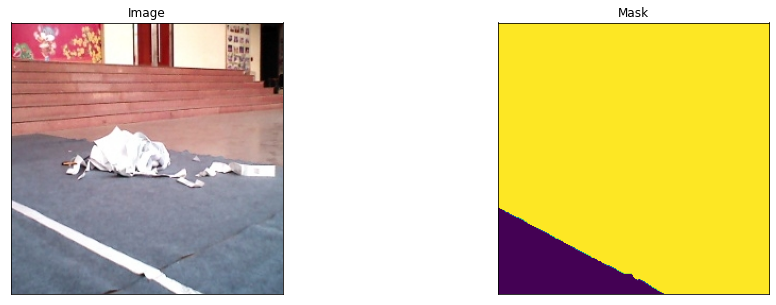

(3, 256, 256) (1, 256, 256) ./data/drive-download-20201203T073237Z-001 (copy)/images/ai1851.jpg ./data/drive-download-20201203T073237Z-001 (copy)/masks/ai1851_color_mask.png


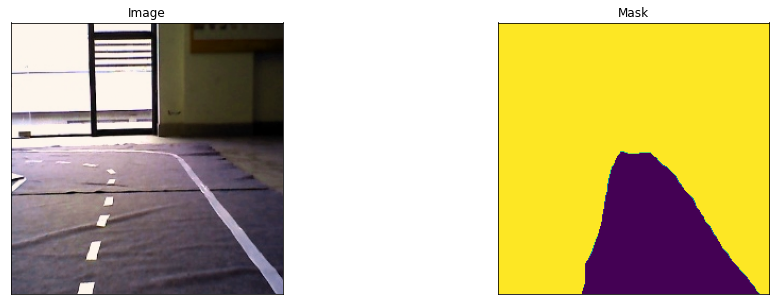

(3, 256, 256) (1, 256, 256) ./data/drive-download-20201203T073237Z-001 (copy)/images/ai1423.jpg ./data/drive-download-20201203T073237Z-001 (copy)/masks/ai1423_color_mask.png


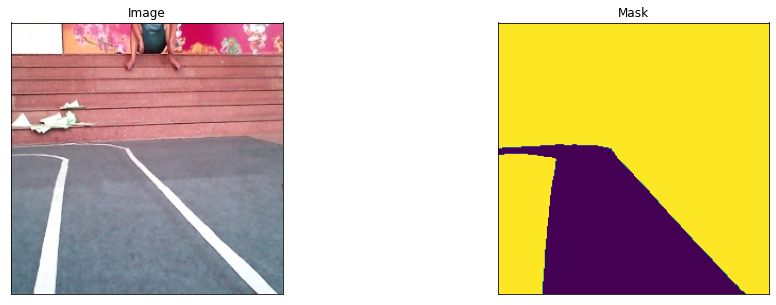

(3, 256, 256) (1, 256, 256) ./data/drive-download-20201203T073237Z-001 (copy)/images/ai701.jpg ./data/drive-download-20201203T073237Z-001 (copy)/masks/ai701_color_mask.png


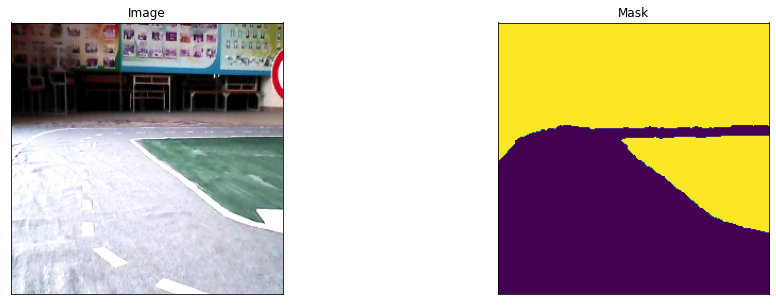

(3, 256, 256) (1, 256, 256) ./data/drive-download-20201203T073237Z-001 (copy)/images/ai1042.jpg ./data/drive-download-20201203T073237Z-001 (copy)/masks/ai1042_color_mask.png


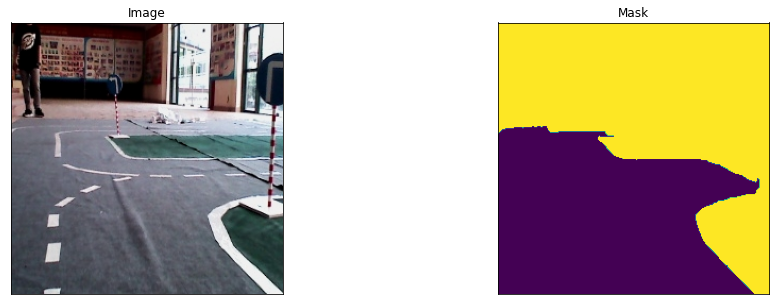

(3, 256, 256) (1, 256, 256) ./data/drive-download-20201203T073237Z-001 (copy)/images/VA1065.jpg ./data/drive-download-20201203T073237Z-001 (copy)/masks/VA1065_color_mask.png


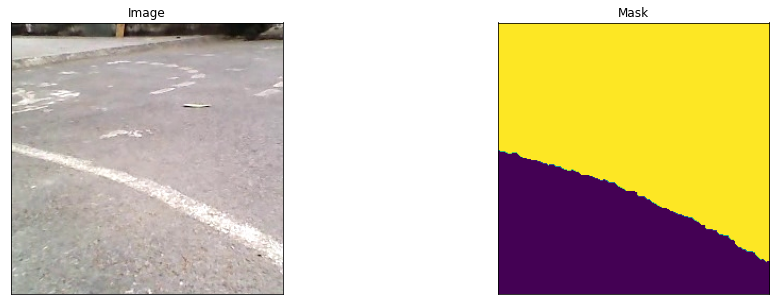

(3, 256, 256) (1, 256, 256) ./data/drive-download-20201203T073237Z-001 (copy)/images/ai3717.jpg ./data/drive-download-20201203T073237Z-001 (copy)/masks/ai3717_color_mask.png


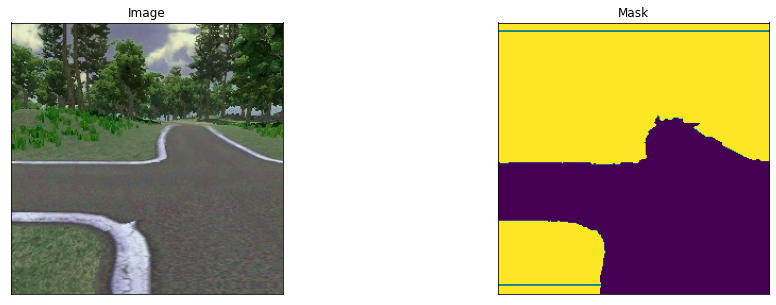

(3, 256, 256) (1, 256, 256) ./data/drive-download-20201203T073237Z-001 (copy)/images/ai71.jpg ./data/drive-download-20201203T073237Z-001 (copy)/masks/ai71_color_mask.png


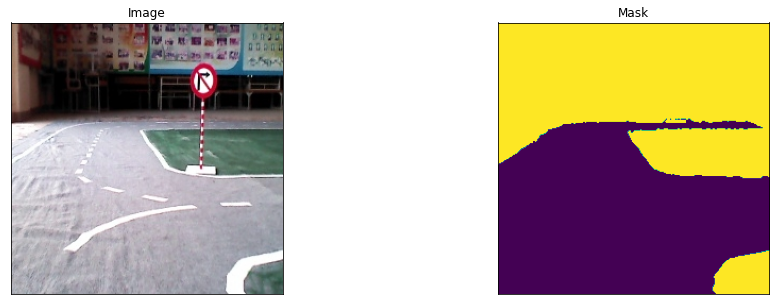

(3, 256, 256) (1, 256, 256) ./data/drive-download-20201203T073237Z-001 (copy)/images/ai1909.jpg ./data/drive-download-20201203T073237Z-001 (copy)/masks/ai1909_color_mask.png


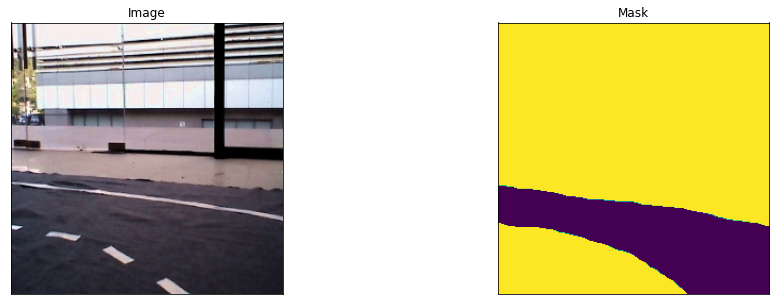

(3, 256, 256) (1, 256, 256) ./data/drive-download-20201203T073237Z-001 (copy)/images/HIEU952.jpg ./data/drive-download-20201203T073237Z-001 (copy)/masks/HIEU952_color_mask.png


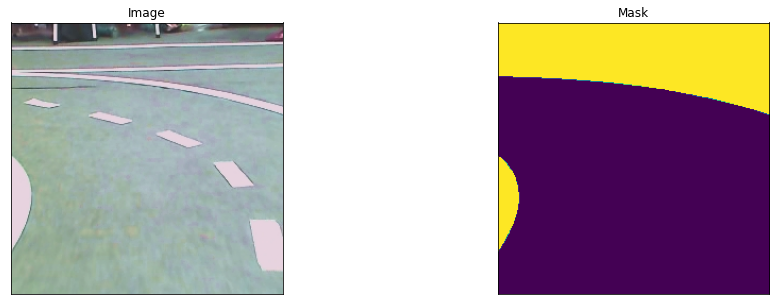

(3, 256, 256) (1, 256, 256) ./data/drive-download-20201203T073237Z-001 (copy)/images/HIEU983.jpg ./data/drive-download-20201203T073237Z-001 (copy)/masks/HIEU983_color_mask.png


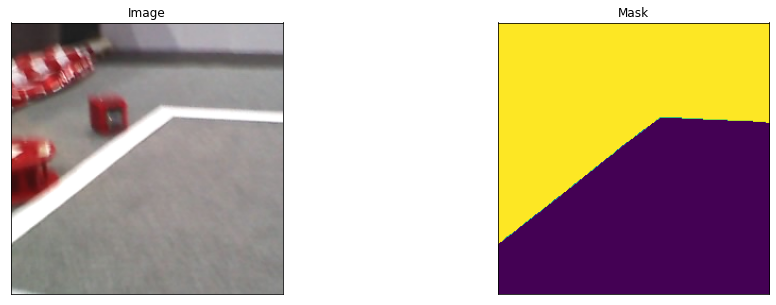

(3, 256, 256) (1, 256, 256) ./data/drive-download-20201203T073237Z-001 (copy)/images/ai1094.jpg ./data/drive-download-20201203T073237Z-001 (copy)/masks/ai1094_color_mask.png


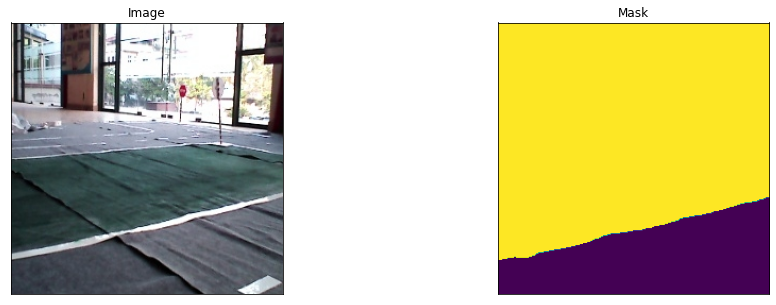

(3, 256, 256) (1, 256, 256) ./data/drive-download-20201203T073237Z-001 (copy)/images/ai1733.jpg ./data/drive-download-20201203T073237Z-001 (copy)/masks/ai1733_color_mask.png


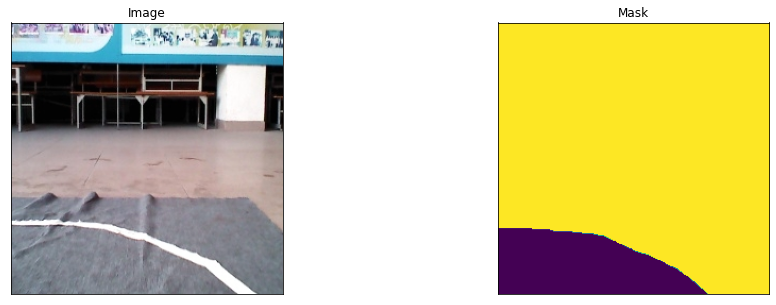

(3, 256, 256) (1, 256, 256) ./data/drive-download-20201203T073237Z-001 (copy)/images/ai3875.jpg ./data/drive-download-20201203T073237Z-001 (copy)/masks/ai3875_color_mask.png


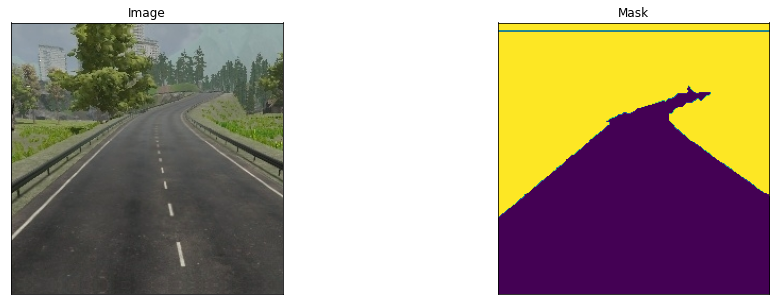

(3, 256, 256) (1, 256, 256) ./data/drive-download-20201203T073237Z-001 (copy)/images/ai1887.jpg ./data/drive-download-20201203T073237Z-001 (copy)/masks/ai1887_color_mask.png


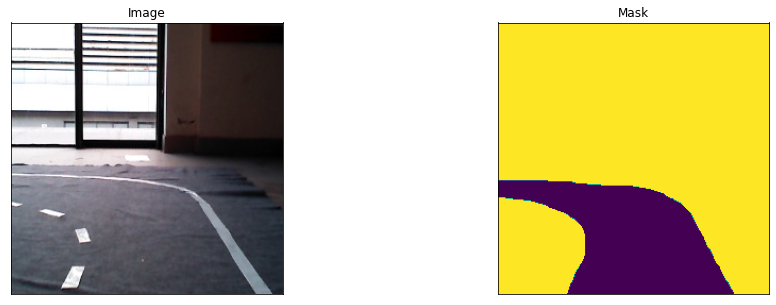

(3, 256, 256) (1, 256, 256) ./data/drive-download-20201203T073237Z-001 (copy)/images/ai863.jpg ./data/drive-download-20201203T073237Z-001 (copy)/masks/ai863_color_mask.png


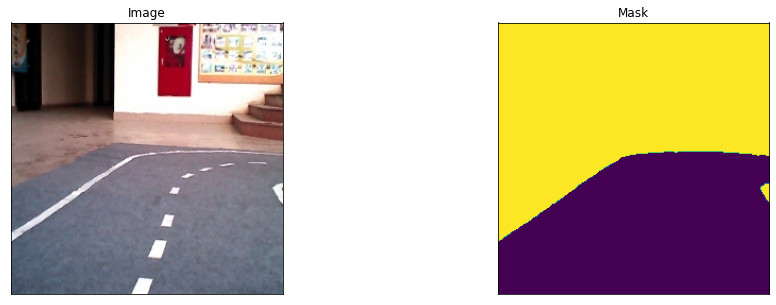

(3, 256, 256) (1, 256, 256) ./data/drive-download-20201203T073237Z-001 (copy)/images/ai1352.jpg ./data/drive-download-20201203T073237Z-001 (copy)/masks/ai1352_color_mask.png


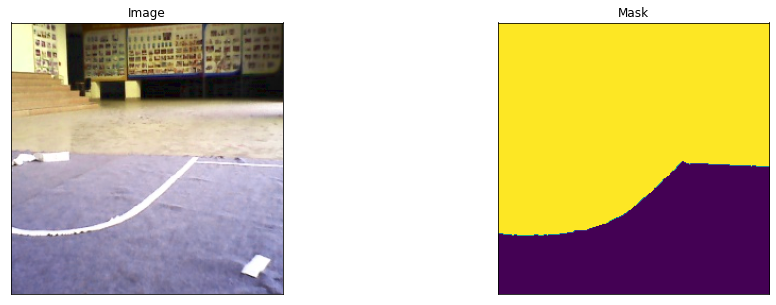

(3, 256, 256) (1, 256, 256) ./data/drive-download-20201203T073237Z-001 (copy)/images/VA1375.jpg ./data/drive-download-20201203T073237Z-001 (copy)/masks/VA1375_color_mask.png


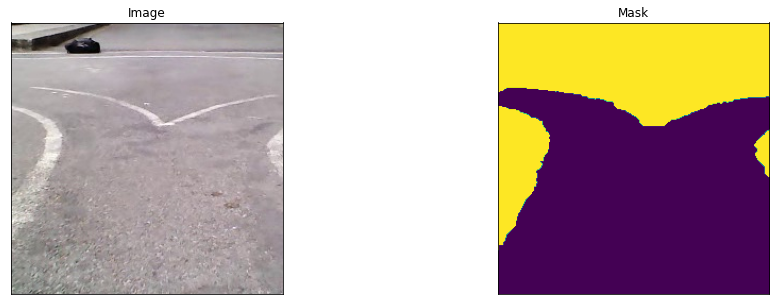

(3, 256, 256) (1, 256, 256) ./data/drive-download-20201203T073237Z-001 (copy)/images/ai1424.jpg ./data/drive-download-20201203T073237Z-001 (copy)/masks/ai1424_color_mask.png


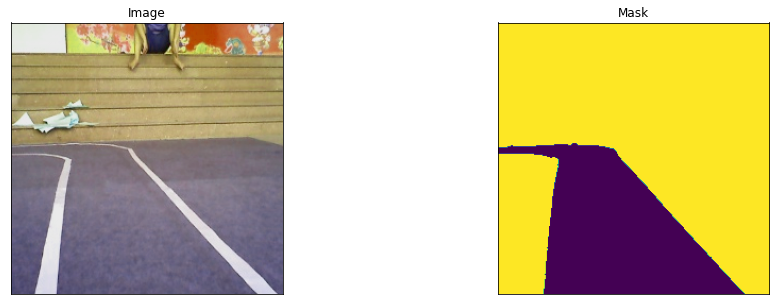

(3, 256, 256) (1, 256, 256) ./data/drive-download-20201203T073237Z-001 (copy)/images/ai1856.jpg ./data/drive-download-20201203T073237Z-001 (copy)/masks/ai1856_color_mask.png


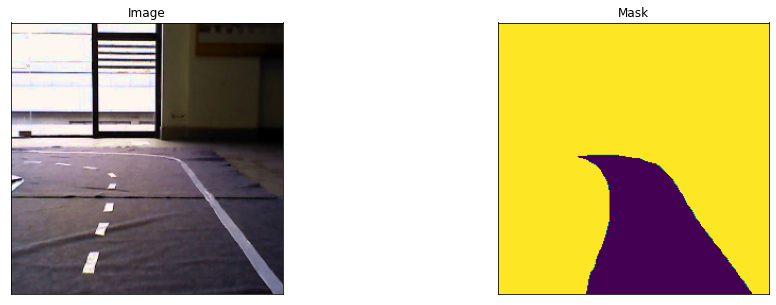

In [55]:
for i in range(1020,1040):
    image, mask = train_data[i]
    print(image.shape,mask.shape,train_data.list_img[i],train_data.get_file_mask(i))
    visualize(image=image, mask=mask)

In [41]:
train_loader =torch.utils.data.DataLoader(train_data, batch_size=8, shuffle=True, num_workers=12)
valid_loader = torch.utils.data.DataLoader(vali_data, batch_size=8, shuffle=False, num_workers=4)

In [42]:
len(train_loader),len(vali_data)

(264, 1642)

In [43]:
# model  = torch.load("./best2.pt")
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])


In [44]:
train_epoch = TrainEpoch(
    model, 
    loss=loss, 
    metrics=me, 
    optimizer=optimizer,
    device="cuda",
    verbose=True,
)
val_epoch = ValidEpoch(
    model,
    loss=loss,
    metrics=me,
    device="cuda",
    verbose=True
)

In [57]:
for i in range(2):
    train_epoch.run(train_loader)
    val_epoch.run(valid_loader)

valid: 100%|██████████| 1642/1642 [00:56<00:00, 28.94it/s, dice_loss - 0.01405, iou_score - 0.9759, accuracy - 0.9825]


In [ ]:
val_epoch.run(valid_loader)

In [58]:
torch.save(model,"best_dat1.pt")

In [59]:
model = model.eval()

In [ ]:
z=vali_data.list_img[0]

In [ ]:
vali_data.get_file_mask(0)

In [ ]:
name = vali_data.list_img[0].split(os.path.sep)[-1].split(".")[0]

In [18]:
train_data = DataTrafic("./data-final-2019/Round_1/VA/",
                        augmentation=val_transform,preprocessing = get_preprocessing(preprocess_input))

None classes set to default 0


In [19]:
for i in range(16):
    image, mask = train_data[i]
    print(image.shape,mask.shape,train_data.list_img[i],train_data.get_file_mask(i))
    visualize(image=image, mask=mask)

IndexError: list index out of range

In [60]:
paths = "./data-final-2019/Round_1/VA/"
paths_predict = "./segment_data_rename/data"
img_file = list(glob.glob(paths + "*.jpg"))
len(img_file)

230

torch.Size([1, 3, 256, 256])
torch.Size([1, 1, 256, 256])


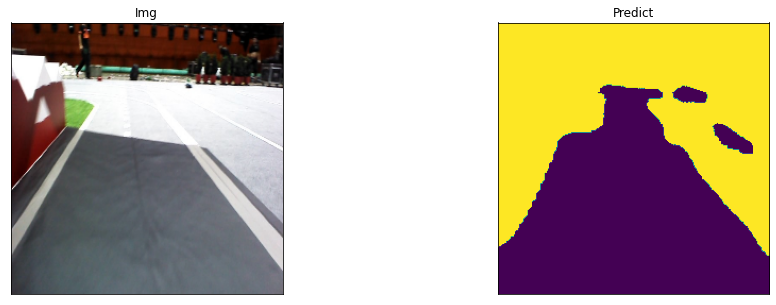

torch.Size([1, 3, 256, 256])
torch.Size([1, 1, 256, 256])


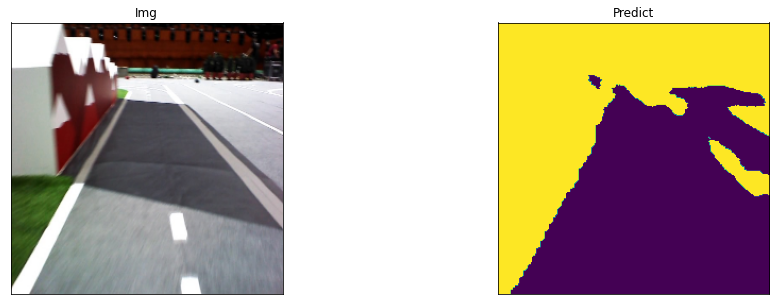

torch.Size([1, 3, 256, 256])
torch.Size([1, 1, 256, 256])


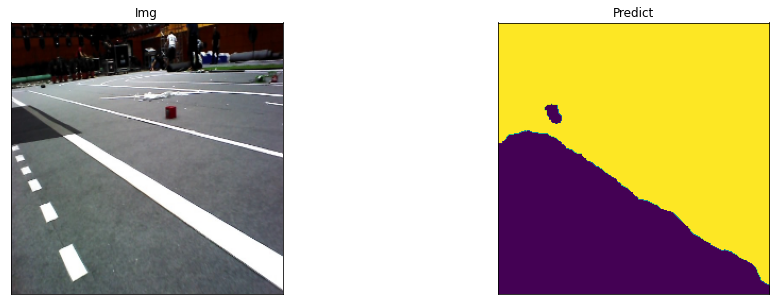

torch.Size([1, 3, 256, 256])
torch.Size([1, 1, 256, 256])


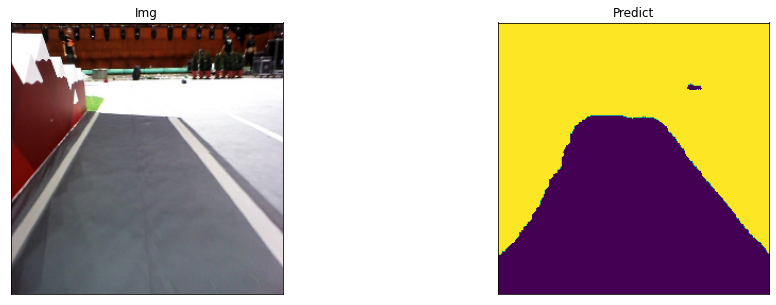

torch.Size([1, 3, 256, 256])
torch.Size([1, 1, 256, 256])


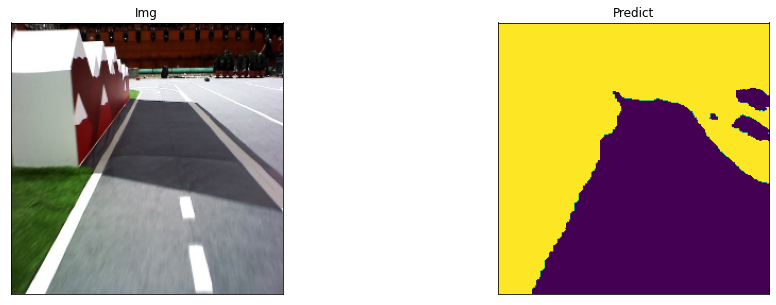

torch.Size([1, 3, 256, 256])
torch.Size([1, 1, 256, 256])


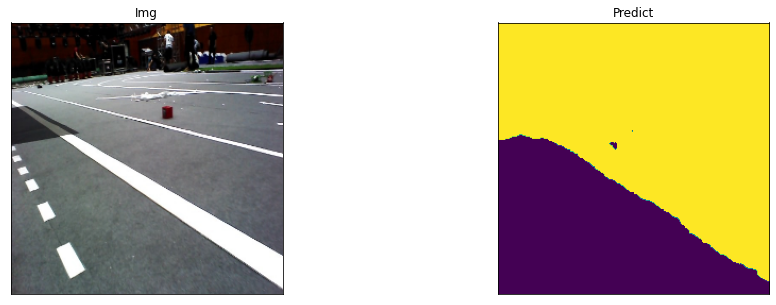

torch.Size([1, 3, 256, 256])
torch.Size([1, 1, 256, 256])


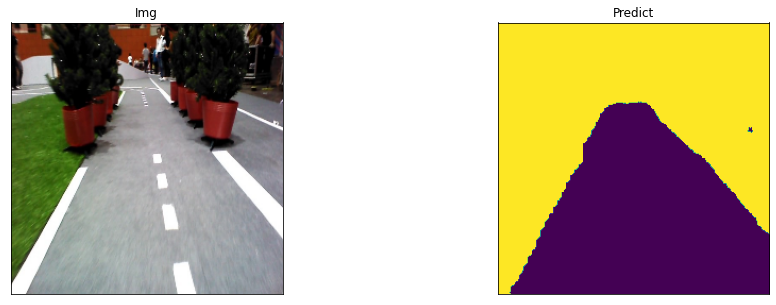

torch.Size([1, 3, 256, 256])
torch.Size([1, 1, 256, 256])


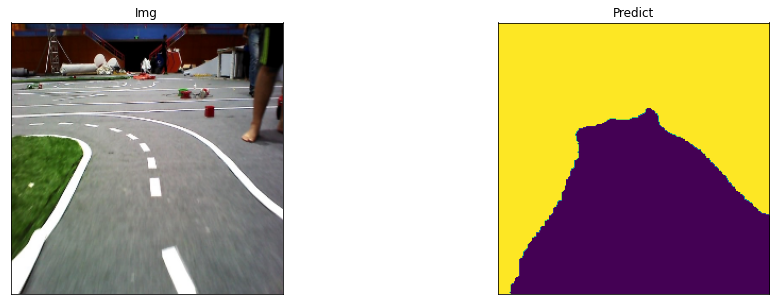

torch.Size([1, 3, 256, 256])
torch.Size([1, 1, 256, 256])


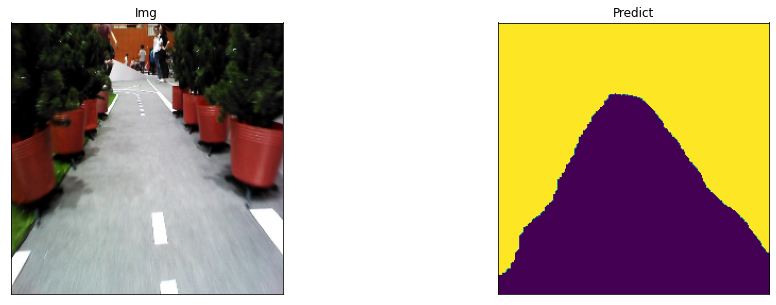

torch.Size([1, 3, 256, 256])
torch.Size([1, 1, 256, 256])


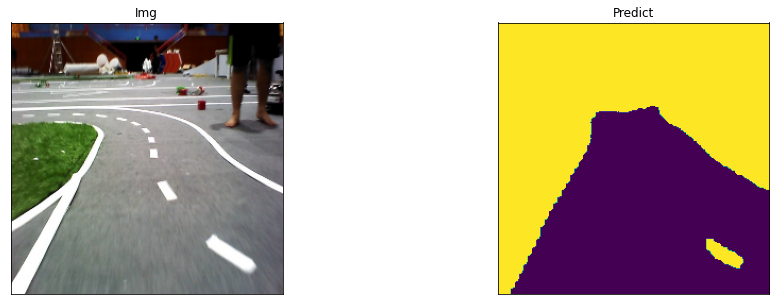

torch.Size([1, 3, 256, 256])
torch.Size([1, 1, 256, 256])


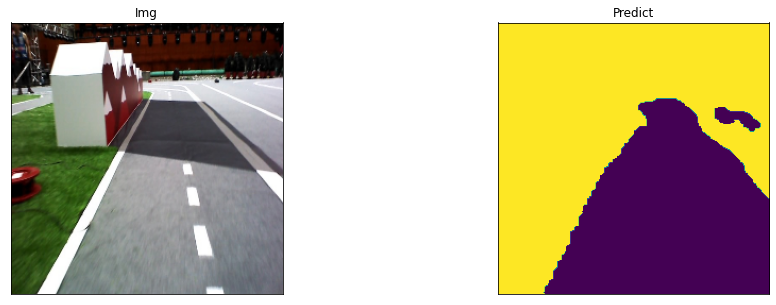

torch.Size([1, 3, 256, 256])
torch.Size([1, 1, 256, 256])


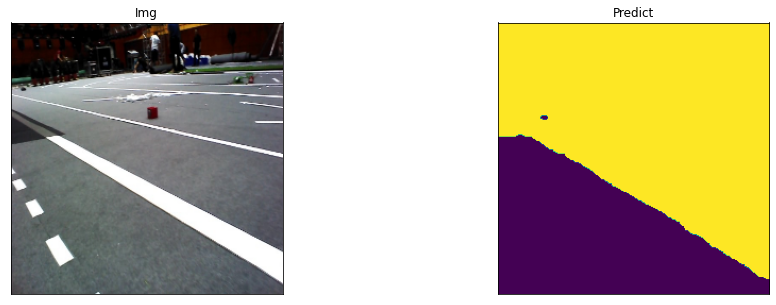

torch.Size([1, 3, 256, 256])
torch.Size([1, 1, 256, 256])


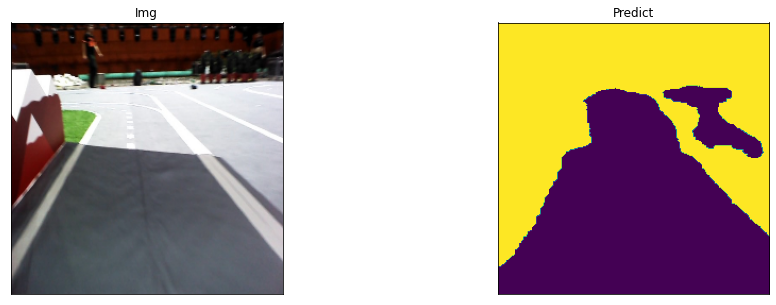

torch.Size([1, 3, 256, 256])
torch.Size([1, 1, 256, 256])


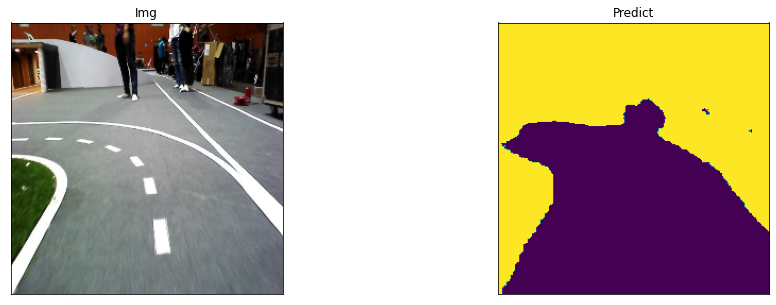

torch.Size([1, 3, 256, 256])
torch.Size([1, 1, 256, 256])


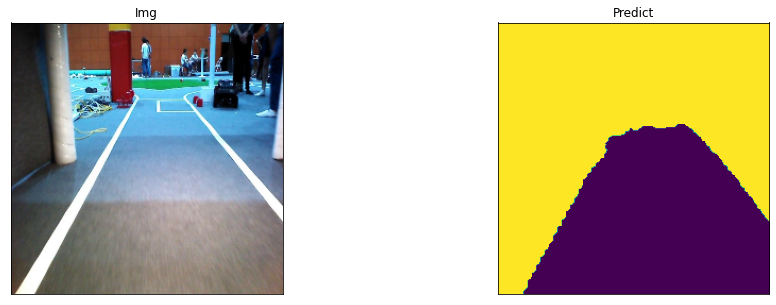

torch.Size([1, 3, 256, 256])
torch.Size([1, 1, 256, 256])


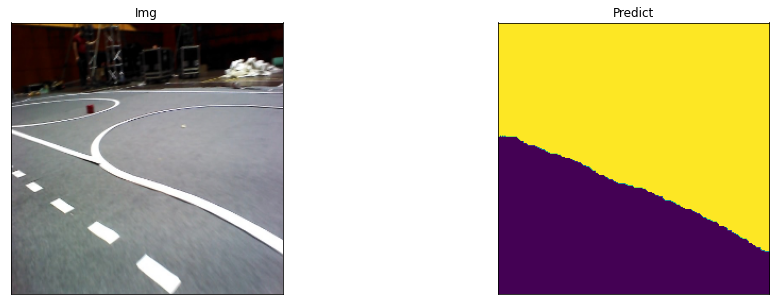

torch.Size([1, 3, 256, 256])
torch.Size([1, 1, 256, 256])


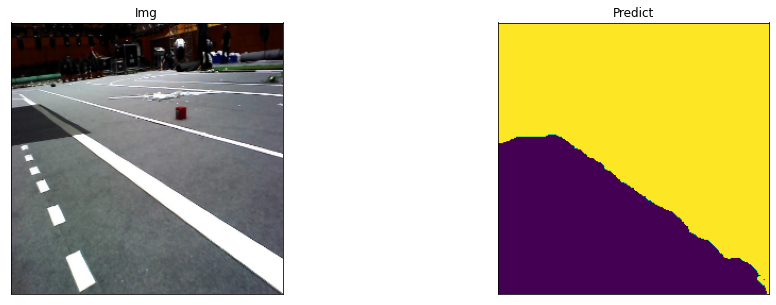

torch.Size([1, 3, 256, 256])
torch.Size([1, 1, 256, 256])


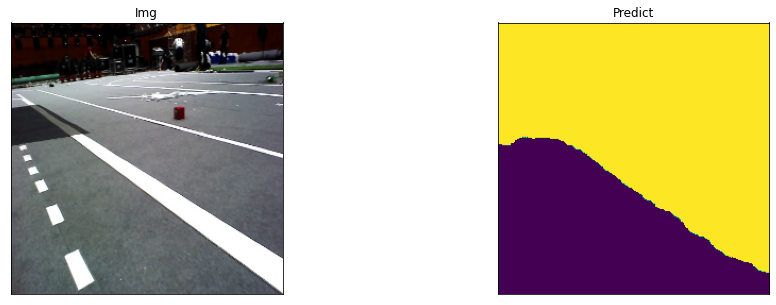

torch.Size([1, 3, 256, 256])
torch.Size([1, 1, 256, 256])


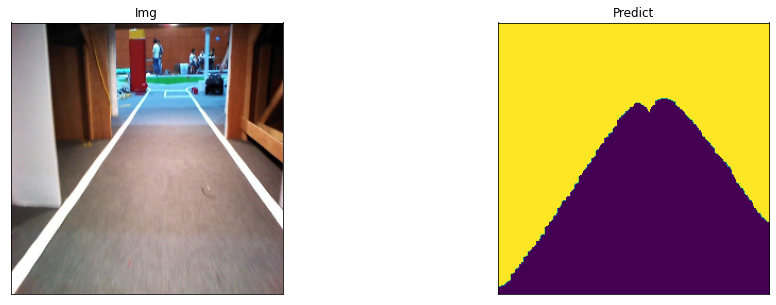

torch.Size([1, 3, 256, 256])
torch.Size([1, 1, 256, 256])


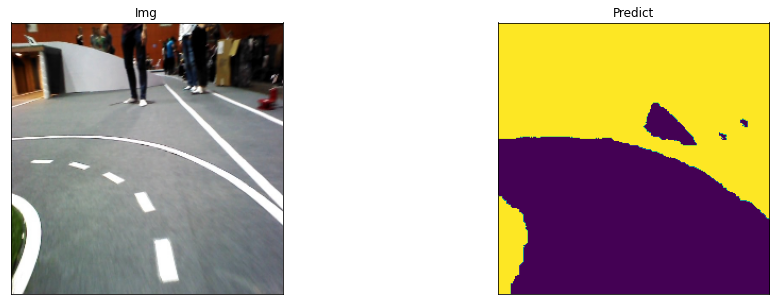

torch.Size([1, 3, 256, 256])
torch.Size([1, 1, 256, 256])


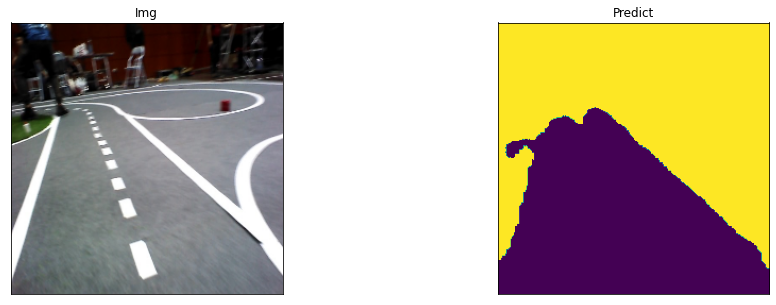

torch.Size([1, 3, 256, 256])
torch.Size([1, 1, 256, 256])


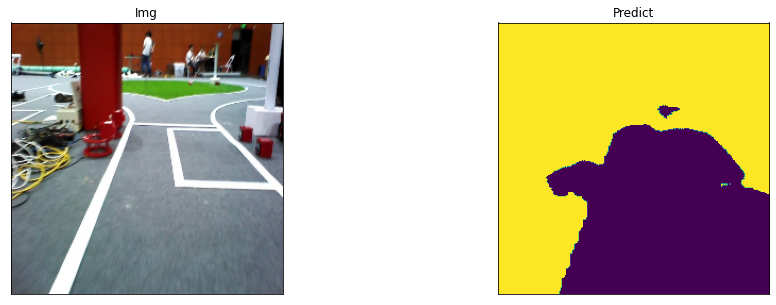

torch.Size([1, 3, 256, 256])
torch.Size([1, 1, 256, 256])


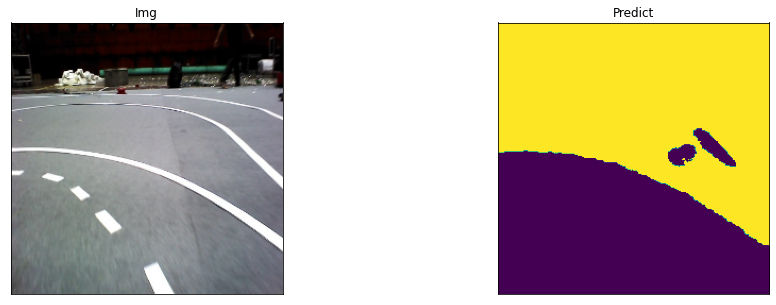

torch.Size([1, 3, 256, 256])
torch.Size([1, 1, 256, 256])


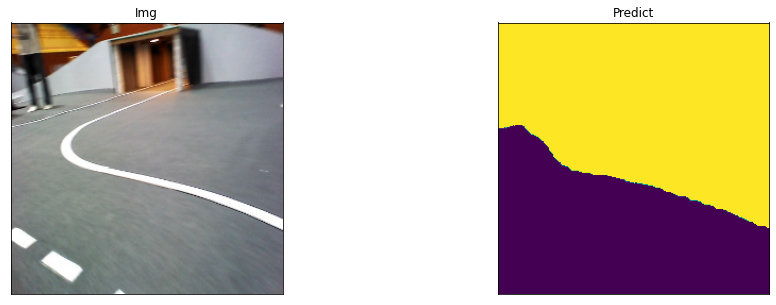

torch.Size([1, 3, 256, 256])
torch.Size([1, 1, 256, 256])


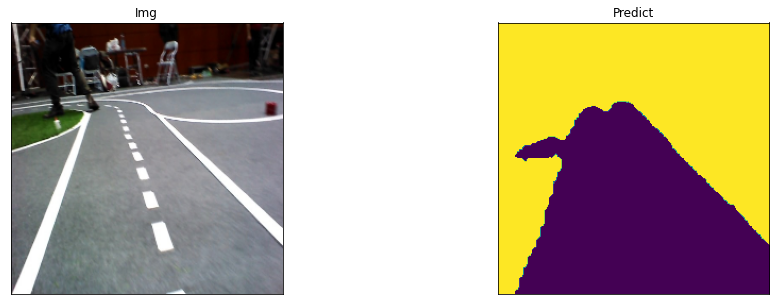

torch.Size([1, 3, 256, 256])
torch.Size([1, 1, 256, 256])


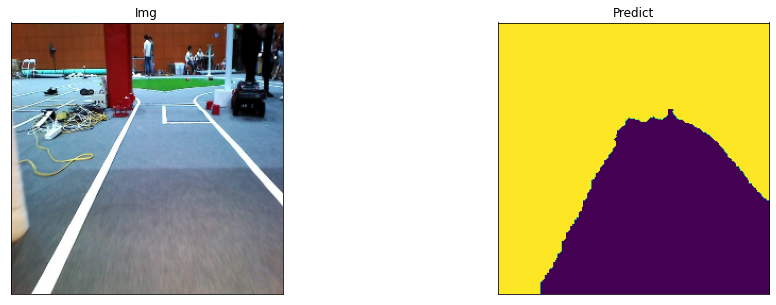

torch.Size([1, 3, 256, 256])
torch.Size([1, 1, 256, 256])


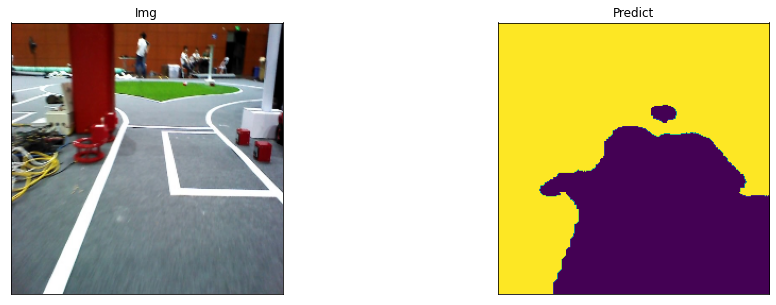

torch.Size([1, 3, 256, 256])
torch.Size([1, 1, 256, 256])


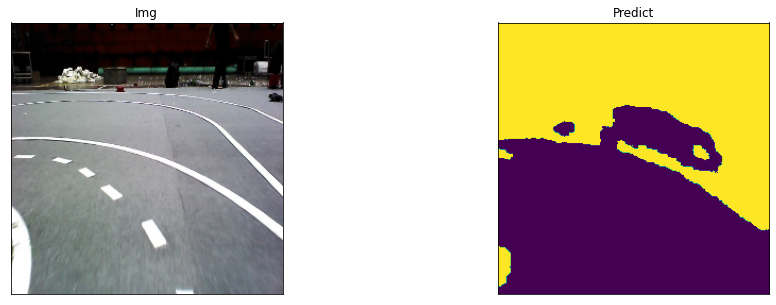

torch.Size([1, 3, 256, 256])
torch.Size([1, 1, 256, 256])


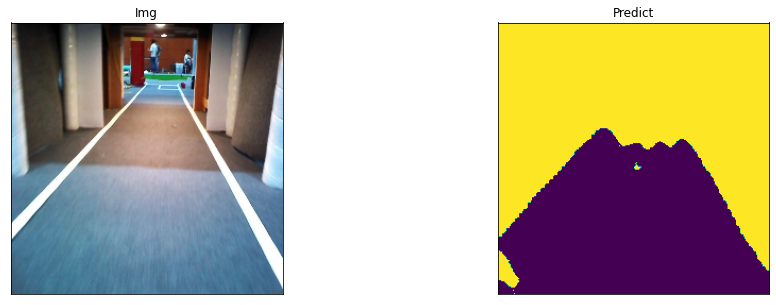

torch.Size([1, 3, 256, 256])
torch.Size([1, 1, 256, 256])


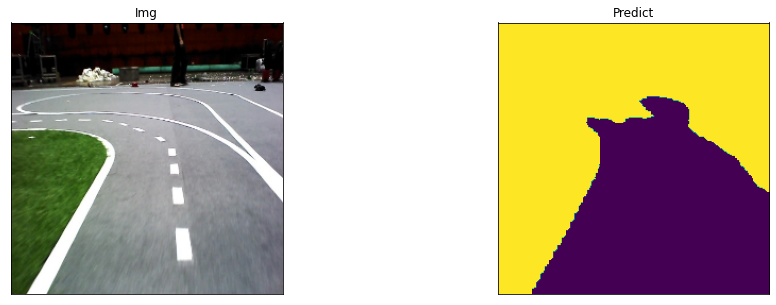

torch.Size([1, 3, 256, 256])
torch.Size([1, 1, 256, 256])


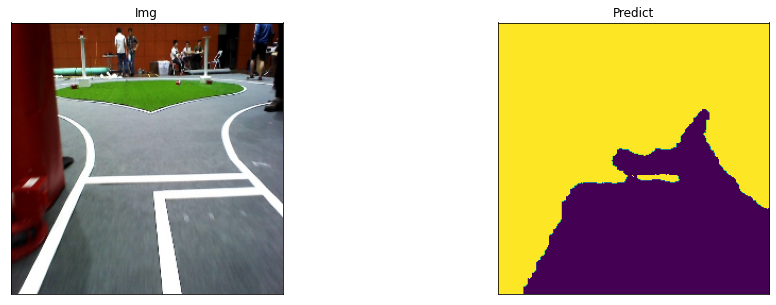

torch.Size([1, 3, 256, 256])
torch.Size([1, 1, 256, 256])


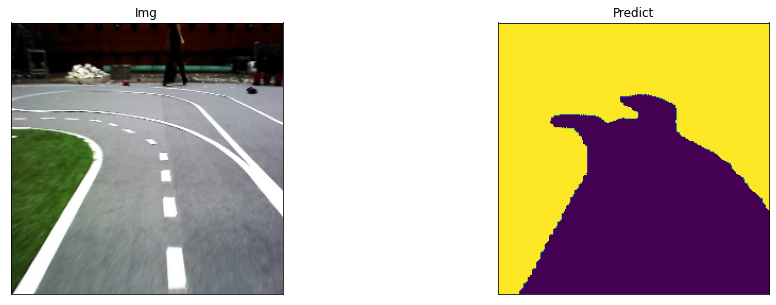

In [61]:
for i in range(32):
    predict_img = predict(img_file[i],model,verbose=False)
    img_ =cv2.imread(img_file[i])
    img_ = cv2.resize(img_,(256,256))
    img_ = cv2.cvtColor(img_,cv2.COLOR_BGR2RGB)
#     print(img_.shape,predict_img.shape)
    visualize2(img = img_,predict = predict_img )

In [22]:
def predict(path,model,device = "cuda",thresold = 0.5, verbose = True):
    '''
    demo predict
    path la file cv2 doc
    model 
    device :cpu|cuda
    verbose =True : return mask_predict,origin_img,origin_mask
    else return mask_predict
    
    mask_predict > thresold : la class
    mask_predict < thresold : la background 
    label_class_pixcel = 0 : em de luc training :(
    label_class_pixcel = 1 : background
    '''
    

    
    img_ =cv2.imread(path)
    img_ = cv2.resize(img_,(256,256))
    img_ = cv2.cvtColor(img_,cv2.COLOR_BGR2RGB)
    
    img = preprocess_input(img_)
    img = to_tensor(img)
    img = img[np.newaxis,...]
    
    with torch.no_grad():
        img_tensor = torch.from_numpy(img).float().to(device)
        print(img_tensor.size())
        predict = model(img_tensor)
        print(predict.shape)
        predict = predict.squeeze().cpu().numpy() # single image
        predict = predict > thresold
        predict = predict.astype("float")
    if not verbose:return predict
    
    namex = path.split("/")[-1].split(".")[0] 
    name ="/".join([i for i in path.split("/")[:-2]]) + "/masks/" +namex + "_color_mask.png"
#     print(name)
    img_mask =cv2.imread(name)
    img_mask = cv2.resize(img_mask,(256,256))
    img_mask = cv2.cvtColor(img_mask,cv2.COLOR_BGR2RGB)
    
    
    
    return predict,img_,img_mask
    

In [23]:
def visualize2(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()